In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
from torch import optim

all_letters = "ЙЦУКЕНГШЩЗЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮ" + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

def toLowerCaseMy(start_letters):
    new_string_list=[]
    for i in range(len(start_letters)):
        if ((ord(start_letters[i]))<1072) and ((ord(start_letters[i]))>=1040):
            new_string_list.append(chr(ord(start_letters[i])+32))
        else:
            new_string_list.append(start_letters[i])
    return "".join(new_string_list)

def toUpperCaseMy(start_letters):
    new_string_list=[]
    for i in range(len(start_letters)):
        if ((ord(start_letters[i]))<(1072+32)) and ((ord(start_letters[i]))>=(1040+32)):
            new_string_list.append(chr(ord(start_letters[i])-32))
        else:
            new_string_list.append(start_letters[i])
    return "".join(new_string_list)

def capitalizeMy(start_letters):
    new_string_list=[]
    for i in range(len(start_letters)):
        if ((ord(start_letters[i]))<(1072+32)) and ((ord(start_letters[i]))>=(1040+32)) and (i==0):
            new_string_list.append(chr(ord(start_letters[i])-32))
        else:
            new_string_list.append(start_letters[i])
    return "".join(new_string_list)


# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

class MyDict():
    def __init__(self, path):
        # Build the category_lines dictionary, a list of lines per category
        self.category_lines = {}
        self.all_categories = []
        for filename in findFiles('data/'+path+'/*.txt'):
            category = filename.split('/')[-1].split('.')[0]
            self.all_categories.append(category)
            lines = readLines(filename)
            self.category_lines[category] = lines

        self.n_categories = len(self.all_categories)


dict1 = MyDict("dict1")
dict2 = MyDict("dict2")
dict3 = MyDict("dict3")

In [99]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(dict1.n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(dict1.n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax()

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        #hidden = self.dropout(hidden)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [100]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair(my_dict):
    category = randomChoice(my_dict.all_categories)
    line = randomChoice(my_dict.category_lines[category])
    return category, line

In [101]:
# One-hot vector for category
def categoryTensor(category,my_dict):
    li = my_dict.all_categories.index(category)
    tensor = torch.zeros(1, my_dict.n_categories)
    #tensor[0][li] = 1
    tensor[0][0] = 1#hack
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [102]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(my_dict):
    category, line = randomTrainingPair(my_dict)
    category_tensor = Variable(categoryTensor(category,my_dict))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample_disc(my_dict):
    category = randomChoice(my_dict.all_categories)
    line = randomChoice(my_dict.category_lines[category])
    category_tensor = Variable(torch.LongTensor([my_dict.all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category_tensor, line_tensor


In [103]:
criterion = nn.NLLLoss()


def train(category_tensor, input_line_tensor, target_line_tensor, optimizer):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    optimizer.step()

    return output, loss.data[0] / input_line_tensor.size()[0]

0m 13s (1000 10%) 2.5696 tl=2.6210
0m 26s (2000 20%) 1.8505 tl=2.4766
0m 38s (3000 30%) 2.5160 tl=2.4335
0m 52s (4000 40%) 3.1029 tl=2.3987
1m 12s (5000 50%) 3.1891 tl=2.3802
1m 24s (6000 60%) 2.8613 tl=2.3481
1m 36s (7000 70%) 2.7258 tl=2.3566
1m 47s (8000 80%) 1.4782 tl=2.3460
1m 58s (9000 90%) 2.1016 tl=2.4020
2m 10s (10000 100%) 2.0183 tl=2.3632


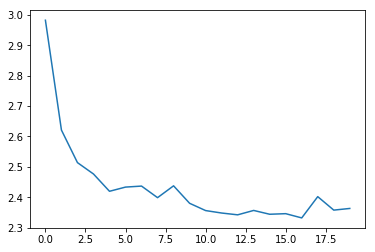

In [104]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
rnn = RNN(n_letters, 56, n_letters)

n_iters = 10000
print_every = 1000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample(dict1),optimizer)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f tl=%.4f' % (timeSince(start), iter, iter / n_iters * 100, loss,total_loss/plot_every))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [40]:
class RNN_disc(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_disc, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 20
rnn_disc1 = RNN_disc(n_letters, n_hidden, dict2.n_categories)
rnn_disc2 = RNN_disc(n_letters, n_hidden, dict3.n_categories)


criterion = nn.NLLLoss()

def train_disc(category_tensor, line_tensor, my_rnn,optimizer):
    hidden = my_rnn.initHidden()

    my_rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = my_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]



1000 10% (0m 3s) 0.0613
2000 20% (0m 7s) 0.2680
3000 30% (0m 10s) 0.6922
4000 40% (0m 14s) 1.1957
5000 50% (0m 17s) 0.3503
6000 60% (0m 21s) 0.0867
7000 70% (0m 24s) 0.2077
8000 80% (0m 28s) 0.4738
9000 90% (0m 32s) 0.0142
10000 100% (0m 35s) 0.0387


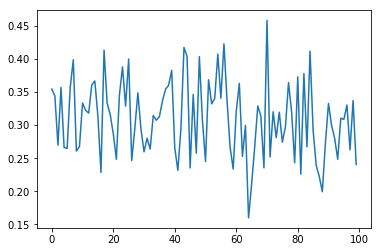

In [43]:
n_iters = 10000
print_every = 1000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()
optimizer = optim.Adam(rnn_disc1.parameters(), lr=0.001)
for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor = randomTrainingExample_disc(dict2)
    output, loss = train_disc(category_tensor, input_line_tensor,rnn_disc1,optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
plt.figure()
plt.plot(all_losses)
plt.show()

1000 10% (0m 3s) 0.1725
2000 20% (0m 7s) 0.0059
3000 30% (0m 11s) 0.0814
4000 40% (0m 15s) 0.0080
5000 50% (0m 19s) 0.0068
6000 60% (0m 23s) 0.0346
7000 70% (0m 27s) 0.7295
8000 80% (0m 31s) 0.0332
9000 90% (0m 35s) 0.9363
10000 100% (0m 39s) 0.3453


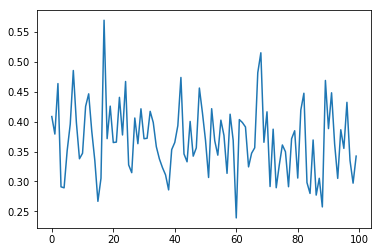

In [44]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()
optimizer = optim.Adam(rnn_disc2.parameters(), lr=0.001)
for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor = randomTrainingExample_disc(dict3)
    output, loss = train_disc(category_tensor, input_line_tensor,rnn_disc2,optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
plt.figure()
plt.plot(all_losses)
plt.show()

In [128]:

def categoryFromOutput(output,my_dict):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return my_dict.all_categories[category_i], category_i, top_n[0][0]


# Just return an output given a line
def evaluate_disc(line,my_rnn):
    line_tensor=Variable(lineToTensor(line))
    hidden = my_rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = my_rnn(line_tensor[i], hidden)

    return output


max_length = 20


def sample(start_letters='A'):
    start_letters=toUpperCaseMy(start_letters)
    category_tensor1 = Variable(categoryTensor(dict1.all_categories[0],dict1))
    category_tensor2 = Variable(categoryTensor(dict1.all_categories[1],dict1))
    input = Variable(inputTensor(start_letters[0]))
    hidden = rnn.initHidden()

    output_name = start_letters[0]
    category_tensor=category_tensor1
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        #print(topv)
        if topi == (n_letters - 1):
            break
        else:
            letter = all_letters[topi]
            if ((i+1)<len(start_letters)):
                letter=start_letters[i+1]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

list_of_examp_per_letter=[]
for n_letter in range (32):
    letter=chr(ord('А')+n_letter)
    list_of_examp=[]
    number_of_examps=0
    cycles=0
    while (number_of_examps<5):
        cycles+=1
        new_examp=sample(letter)
        found=0
        if ((len(new_examp)>3) and (len(new_examp)<15)):
            for examp in list_of_examp:
                if ((examp[1]==new_examp[1]) and (cycles<500)) or ((examp[2]==new_examp[2]) and (cycles<400)):
                    found=1
            if (found==0):
                _,out_disc_is_name, val_n=categoryFromOutput(evaluate_disc(new_examp,rnn_disc1),dict2)
                _,out_disc_is_obsc, val_obsc=categoryFromOutput(evaluate_disc(new_examp,rnn_disc2),dict3)
                if (out_disc_is_name==0)  and ((out_disc_is_obsc==0) or (cycles>1000)):
                    list_of_examp.append(new_examp)
                    number_of_examps+=1
    string_to_print=""
    for i in range(len(list_of_examp)):
        string_to_print=string_to_print+capitalizeMy(toLowerCaseMy(list_of_examp[i])) + ", "
    print(string_to_print)


Абандова, Атоскосо, Абинов, Атьсоебанин, Атьсякина, 
Батьсякина, Береватосьев, Берена, Батьсякина, Берева, 
Вебена, Вадоескаяс, Выебенив, Вхуяреван, Водоебена, 
Гороебанов, Гороебанов, Горебев, Гороебен, Гороебен, 
Дохуярова, Дребена, Далебани, Дребена, Дохуярив, 
Ебанова, Еребен, Еминдохив, Ебанова, Ереблядин, 
Жебена, Жипиздяр, Жадовская, Жеребен, Жебена, 
Заманова, Здохуева, Зопизаябива, Зебандоха, Заманева, 
Издяритьсякин, Итьсякина, Инанано, Издохуенива, Итьсякина, 
Йебена, Йатьсякова, Йребен, Йебена, Йемандяр, 
Командяшквани, Канаебин, Кизаноскина, Командяш, Командяш, 
Лопездярив, Лебано, Лодебен, Лопиздохатова, Ломандяшива, 
Мандохива, Мудохуева, Мендова, Модоебанив, Мадоебини, 
Наебанива, Небена, Нопоздохитова, Наебенив, Наебена, 
Обена, Опиздярива, Омандярив, Обандов, Обандошива, 
Пидолобанов, Пропиндяшива, Поздолинева, Пизатьсякина, Пиздохуяксв, 
Распизена, Репиздяшива, Ребандов, Распиздярив, Ропизминдярив, 
Себенко, Стеребан, Совъкова, Спииманина, Стемендова, 
Тоспиздяхива, 